# 곱셈계층

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y
        
        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

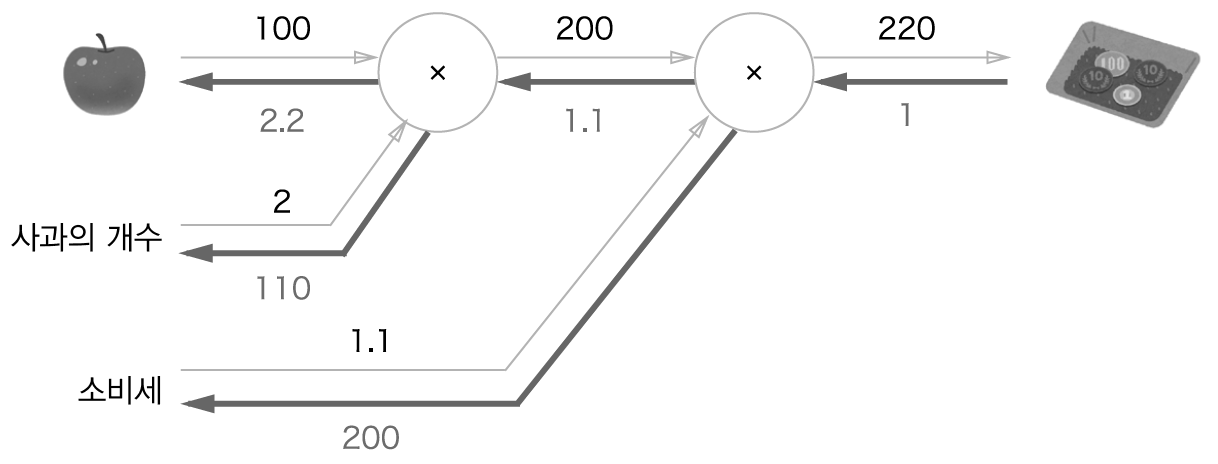

In [2]:
apple = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dApple_price, dTax = mul_tax_layer.backward(dprice)
dApple, dApple_num = mul_apple_layer.backward(dApple_price)


print("price:", int(price))
print("dApple:", dApple)
print("dApple_num:", int(dApple_num))
print("dTax:", dTax)


price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


# 덧셈 계층

In [3]:
class AddLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x+y
        
        return out
    
    def backward(self, dout):
        dx = dout
        dy = dout
        
        return dx, dy

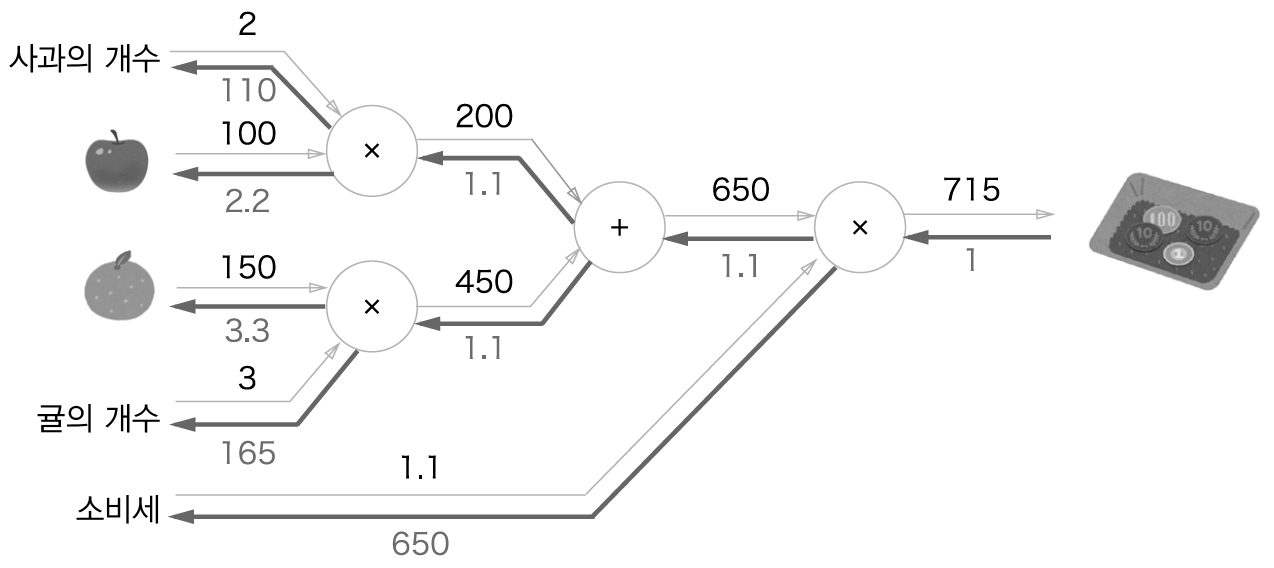

In [4]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
mul_tax_layer = MulLayer()
add_fruit_layer = AddLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
fruit_price = add_fruit_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(fruit_price, tax)


# backward
dprice = 1
dfruit_price, dTax = mul_tax_layer.backward(dprice)
dApple_price, dOrange_price = add_fruit_layer.backward(dfruit_price)
dApple, dApple_num = mul_apple_layer.backward(dApple_price)
dOrange, dOrange_num = mul_orange_layer.backward(dOrange_price)

 
print("price:", int(price))
print("dApple:", dApple)
print("dApple_num:", int(dApple_num))
print("dOrange:", dOrange)
print("dOrange_num:", int(dOrange_num))
print("dTax:", dTax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


# LeRu 역전파

In [5]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        
        return dout

# Sigmoid 역전파

In [6]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1/(1+np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        return dout * self.out * (1-self.out)

# Affine 역전파

In [26]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        
        return out
 
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

In [27]:
def softmax(x):
    exp_x = np.exp(x)
    if exp_x.ndim == 1:
        sum_exp_x = np.sum(exp_x)
    else:
        sum_exp_x = np.sum(exp_x, axis=1).reshape(-1, 1)
    y = exp_x/sum_exp_x
    return y

In [28]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-7

    grad = np.zeros_like(x)

    for idx in range(x.size):
        
        tmp_val = x[idx]

        #f(x + h)
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        #f(x - h)
        x[idx] = float(tmp_val) - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [29]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)

    else:
        grad = np.zeros_like(X)
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [31]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    
    delta = 1e-7
    return -np.sum(np.log(y[np.arange(batch_size), t] + delta))/batch_size

In [32]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.x = None
        self.y = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        if self.t.size == self.y.size:
            dx = (self.y-self.t)/batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx/batch_size
        
        return dx

In [33]:
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
         
    def predict(self, x):
#         x = self.layers['Affine1'].forward(x)
#         x = self.layers['Relu1'].forward(x)
#         x = self.layers['Affine2'].forward(x)
        
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.lastLayer.forward(y, t)
        
        return loss
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)

        if t.ndim != 1:
            t = np.argmax(t, axis=1)
            
        accuracy = np.sum(y==t)/float(x.shape[0])
        
        return accuracy
    
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
        
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [34]:
import pickle

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    def _change_one_hot_label(X):
        T = np.zeros((X.size, 10))
        for idx, row in enumerate(T):
            row[X[idx]] = 1

        return T

    with open('./mnist.pkl', 'rb') as f:
        dataset = pickle.load(f)
        
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

In [35]:
import numpy as np

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [36]:
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

In [39]:
import  as plt

train acc, test acc | 0.9894666666666667, 0.9721
train acc, test acc | 0.98995, 0.9724
train acc, test acc | 0.9904166666666666, 0.9738
train acc, test acc | 0.9907666666666667, 0.9734
train acc, test acc | 0.99115, 0.9739
train acc, test acc | 0.99145, 0.9724
train acc, test acc | 0.99105, 0.9721
train acc, test acc | 0.9909333333333333, 0.9713
train acc, test acc | 0.9915666666666667, 0.9743
train acc, test acc | 0.9929833333333333, 0.9739
train acc, test acc | 0.9929666666666667, 0.9725
train acc, test acc | 0.99345, 0.9739
train acc, test acc | 0.9944166666666666, 0.9731
train acc, test acc | 0.9941833333333333, 0.9721
train acc, test acc | 0.99455, 0.9733
train acc, test acc | 0.9948333333333333, 0.9729
train acc, test acc | 0.9952333333333333, 0.9736


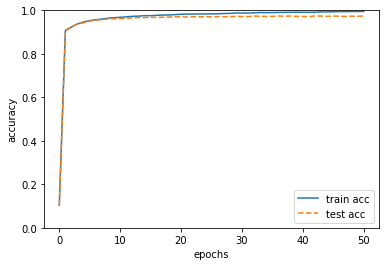

In [41]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
#     grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
    

# 그래프 그리기
import matplotlib.pylab as plt

markers = {"train": "o", "test": "s"}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label="train acc")
plt.plot(x, test_acc_list, label="test acc", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.show()